## Loading Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt

PyTorch, a framework for building and training neural networks. PyTorch in a lot of ways behaves like the arrays you love from Numpy. These Numpy arrays, after all, are just tensors. PyTorch takes these tensors and makes it simple to move them to GPUs for the faster processing needed when training neural networks. It also provides a module that automatically calculates gradients (for backpropagation!) and another module specifically for building neural networks. All together, PyTorch ends up being more coherent with Python and the Numpy/Scipy stack compared to TensorFlow and other frameworks.

Start by loading the dataset through torchvision. 
Load the Fashion MNIST dataset

MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network, and a better representation of datasets you'll use in the real world.

## Loading the data

In [2]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
#transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

/Users/karthik/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1631631227379/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


This is what an image in the dataset looks like

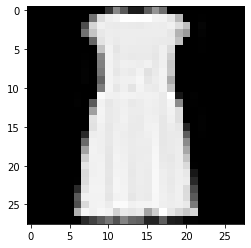

In [3]:
images, labels = next(iter(trainloader))
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

## Build the network

Here I'll create a model like normal

In [4]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

With the probabilities, we can get the most likely class using the `ps.topk` method. This returns the $k$ highest values. Since we just want the most likely class, we can use `ps.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

In [5]:
model = Classifier()

images, labels = next(iter(trainloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


The goal of validation is to measure the model's performance on data that isn't part of the training set. Performance here is up to the developer to define though. Typically this is just accuracy, the percentage of classes the network predicted correctly. Other options are [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)) and top-5 error rate. We'll focus on accuracy here. First I'll do a forward pass with one batch from the test set.

In [13]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[7],
        [0],
        [1],
        [7],
        [7],
        [9],
        [6],
        [9],
        [6],
        [6]])


In [7]:
equals = top_class == labels.reshape(*top_class.shape)

# We'll need to convert equals to a float tensor
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 14.0625%


The network is untrained so it's making random guesses and we should see an accuracy around 10%. Now let's train our network and include our validation pass so we can measure how well the network is performing on the test set. Since we're not updating our parameters in the validation pass, we can speed up our code by turning off gradients using `torch.no_grad()`:

# Build the Validation pass and check for accuracy on test data

In [8]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 5
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        train_loss = criterion(log_ps, labels)
        train_loss.backward()
        optimizer.step()
        
        running_loss += train_loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            for images, labels in trainloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.reshape(*top_class.shape)
                accuracy = torch.mean(equals.type(torch.FloatTensor))
                
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
        
        ## TODO: Implement the validation pass and print out the validation accuracy
        print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 81.25%
Accuracy: 87.5%
Accuracy: 81.25%
Accuracy: 87.5%
Accuracy: 87.5%


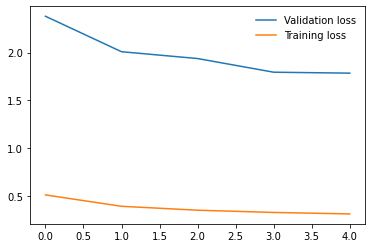

In [9]:
import matplotlib.pyplot as plt
plt.plot(test_losses,label='Validation loss')
plt.plot(train_losses,label='Training loss')
plt.legend(frameon=False)

If we look at the training and validation losses as we train the network, we can see a phenomenon known as "overfitting".

The most common method to reduce overfitting (outside of early-stopping) is dropout, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data.

In [10]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.out = nn.Linear(64,10)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self,x):
        
       # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
            
         # forward pass thro the network with activation and dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
            
            #  No dropout for the output
        x = F.log_softmax(self.out(x), dim=1)
            
        return x
        
model = Network() 

In [11]:
## TODO: Train your model with dropout, and monitor the training progress with the validation loss and accuracy

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),lr=0.003)


epochs = 10
steps = 0

train_losses = []
test_losses = []

for e in range(epochs):
    running_loss = 0
    for image, label in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(image)
        train_loss = criterion(log_ps,label)
        train_loss.backward()
        optimizer.step()
        
        running_loss += train_loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad(): # Turn off gradients for validation, saves memory and computations
            model.eval()
            for image, label in testloader:
                out = model(image)
                test_loss = criterion(out,label)
                
                ps = torch.exp(out)
                top_p, top_class = ps.topk(1,dim=1)
                equals = top_class == label.reshape(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                

                
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/10..  Training Loss: 0.604..  Test Loss: 0.004..  Test Accuracy: 0.835
Epoch: 2/10..  Training Loss: 0.483..  Test Loss: 0.006..  Test Accuracy: 0.844
Epoch: 3/10..  Training Loss: 0.453..  Test Loss: 0.003..  Test Accuracy: 0.847
Epoch: 4/10..  Training Loss: 0.434..  Test Loss: 0.004..  Test Accuracy: 0.856
Epoch: 5/10..  Training Loss: 0.425..  Test Loss: 0.004..  Test Accuracy: 0.858
Epoch: 6/10..  Training Loss: 0.413..  Test Loss: 0.002..  Test Accuracy: 0.854
Epoch: 7/10..  Training Loss: 0.408..  Test Loss: 0.001..  Test Accuracy: 0.855
Epoch: 8/10..  Training Loss: 0.401..  Test Loss: 0.002..  Test Accuracy: 0.857
Epoch: 9/10..  Training Loss: 0.393..  Test Loss: 0.005..  Test Accuracy: 0.852
Epoch: 10/10..  Training Loss: 0.387..  Test Loss: 0.003..  Test Accuracy: 0.866


In [12]:
# To use the model for making predictions or for testing, switch back to model.eval() mode

model.eval()

Network(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)